In [11]:
import pandas as pd
import sys
sys.path.append("../movielingo/")

from matplotlib import pyplot as plt
from movielingo.config import processed_data_dir
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA

## 01. Load subtitle features

In [165]:
df = pd.read_csv(processed_data_dir / 'movie_features.csv') # df created in get_nearest_neighbours.py

In [166]:
df.head()

,n_uniq_lemmas,mean_sent_len,median_sent_len,sd_sent_len,mean_word_len,mean_wf_lemma,mean_wf_token,mean_n_uniq_rare_lemmas,n_unique_verb_forms,n_unique_past_verbs,...,vp_t,c_t,cp_t,cp_c,cn_t,cn_c,ct_t,t_s,dc_t,dc_c
title,,,,,,,,,,,,,,,,,,,,,
Aladdin,0.495238,5.380952,4.500000,3.170889,16.142857,-7.894976,-7.974298,0.115229,0.176062,0.033357,...,1.206107,1.094156,0.003571,0.002381,0.076662,0.062911,0.003571,6.464286,0.003571,0.002381
Annie Hall,0.511111,5.583333,5.083333,2.634484,16.750000,-7.378330,-7.559443,0.073346,0.190244,0.068620,...,1.228456,1.149002,0.002688,0.001634,0.174629,0.136318,0.017678,9.500000,0.017678,0.011373
Back to the Future,0.752778,8.888889,7.250000,5.309460,26.666667,-7.234915,-7.331244,0.050172,0.130342,0.026089,...,1.768734,1.410732,0.010354,0.006250,0.171881,0.111389,0.022024,9.000000,0.034127,0.021944
Beauty and the Beast,0.538462,6.000000,5.769231,3.043244,18.000000,-7.290477,-7.394038,0.067717,0.189825,0.038167,...,1.662471,1.486014,0.002564,0.002564,0.087762,0.062381,0.026807,7.487179,0.047319,0.023223
Casablanca,0.500000,5.520833,5.062500,2.841294,16.562500,-7.399027,-7.512743,0.101489,0.204022,0.068748,...,1.487044,1.214286,0.008333,0.007812,0.086175,0.071220,0.012351,6.510417,0.021577,0.015037


In [10]:
df.shape

(62, 30)

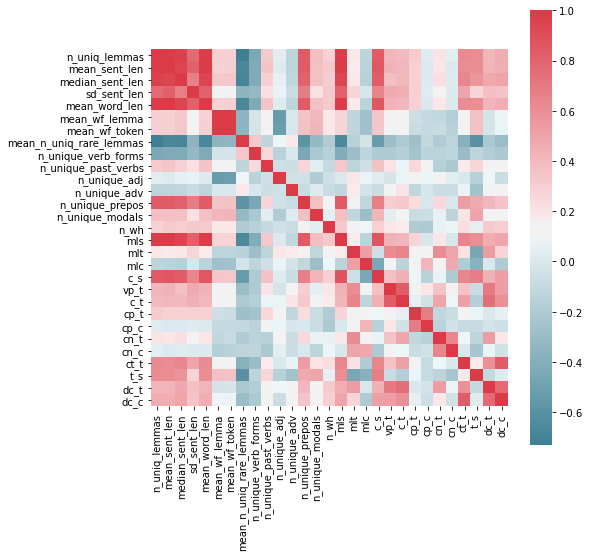

In [5]:
f, ax = plt.subplots(figsize=(8, 8))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax);

Some features are highly correlated (+ mean sentence length is mentioned twice), so I will apply PCA to get more sensible recommendations.

## 02. PCA

Goal: pick a reasonable number of components

In [31]:
X = df.drop(['title', 'mls'], axis = 1)

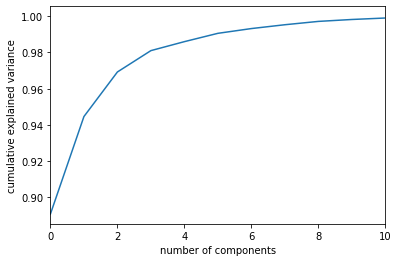

In [32]:
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.xlim(0,10);

In [33]:
pca6 = PCA(n_components=6)
pca6.fit(X)
projected = pca6.fit_transform(X)
projected.shape

(62, 6)

## 03. Expore difficulty by movie genre

Do some genre have more complex language than others?

In [65]:
imdb = pd.read_csv(processed_data_dir / 'top250_movie_characteristics.txt',
                   sep = '\t',
                   names = ['id', 'title', 'genre', 'movie_or_show', 'keywords', 'rating'],
                   dtype = {'id': str, 'rating': float})

In [66]:
imdb.loc[:,'title'] = imdb.title.str.split(' \(.{4,40}\) - IMDb', expand=True)[0].str.strip()

In [67]:
imdb.shape

(67, 6)

In [68]:
imdb = imdb[imdb.title.isin(list(df.title.unique()))]

In [69]:
imdb.shape

(62, 6)

In [70]:
genre_db = imdb.genre

In [71]:
all_genre = []
for movie in range(genre_db.shape[0]):
    all_genre = all_genre + list(genre_db.str.split(',', expand = True).iloc[movie])

In [72]:
unique_genre = list(set(all_genre))

In [73]:
# take the second element for sort
def take_second(elem):
    return elem[1]

In [74]:
genres = []
counts = []
for genre in unique_genre:
    try:
        counts.append(imdb[imdb.genre.str.contains(genre)].title.nunique())
        genres.append(genre)
    except:
        pass
genre_summary = zip(genres, counts)
sorted(genre_summary, key = take_second)

[('Western', 1),
 ('Thriller', 1),
 ('Mystery', 1),
 ('Sport', 2),
 ('Biography', 2),
 ('War', 4),
 ('Musical', 6),
 ('Music', 7),
 ('Sci-Fi', 7),
 ('Crime', 8),
 ('Animation', 14),
 ('Action', 14),
 ('Romance', 16),
 ('Family', 19),
 ('Fantasy', 20),
 ('Drama', 25),
 ('Adventure', 31),
 ('Comedy', 35)]

In [75]:
genres_list = []
for movie in range(genre_db.shape[0]):
    genres_list.append(list(genre_db.str.split(',', expand = True).iloc[movie]))
    
imdb['genre_list'] = genres_list

imdb['is_animation'] = imdb.apply(lambda row: True if 'Animation' in row.genre_list else False, axis = 1)
imdb['is_action'] = imdb.apply(lambda row: True if 'Action' in row.genre_list else False, axis = 1)
imdb['is_romance'] = imdb.apply(lambda row: True if 'Romance' in row.genre_list else False, axis = 1)
imdb['is_family'] = imdb.apply(lambda row: True if 'Family' in row.genre_list else False, axis = 1)
imdb['is_fantasy'] = imdb.apply(lambda row: True if 'Fantasy' in row.genre_list else False, axis = 1)
imdb['is_drama'] = imdb.apply(lambda row: True if 'Drama' in row.genre_list else False, axis = 1)
imdb['is_adventure'] = imdb.apply(lambda row: True if 'Adventure' in row.genre_list else False, axis = 1)
imdb['is_comedy'] = imdb.apply(lambda row: True if 'Comedy' in row.genre_list else False, axis = 1)

In [77]:
imdb.head()

,id,title,genre,movie_or_show,keywords,rating,genre_list,is_animation,is_action,is_romance,is_family,is_fantasy,is_drama,is_adventure,is_comedy
0,0167260,The Lord of the Rings: The Return of the King,"Adventure,Drama,Fantasy",Movie,"orc,epic,battle,journey,hobbit",8.9,"[Adventure, Drama, Fantasy, None, None, None, ...",False,False,False,False,True,True,True,False
1,0110912,Pulp Fiction,"Crime,Drama",Movie,"nonlinear timeline,overdose,drug overdose,bond...",8.9,"[Crime, Drama, None, None, None, None, None]",False,False,False,False,False,True,False,False
2,0120737,The Lord of the Rings: The Fellowship of the Ring,"Action,Adventure,Drama,Fantasy",Movie,"ring,quest,hobbit,elf,orc",8.8,"[Action, Adventure, Drama, Fantasy, None, None...",False,True,False,False,True,True,True,False
3,0109830,Forrest Gump,"Drama,Romance",Movie,"vietnam war,amputee,war hero,vietnam,mother",8.8,"[Drama, Romance, None, None, None, None, None]",False,False,True,False,False,True,False,False
4,0167261,The Lord of the Rings: The Two Towers,"Adventure,Drama,Fantasy",Movie,"middle earth,wizard,mission,hobbit,dwarf",8.7,"[Adventure, Drama, Fantasy, None, None, None, ...",False,False,False,False,True,True,True,False


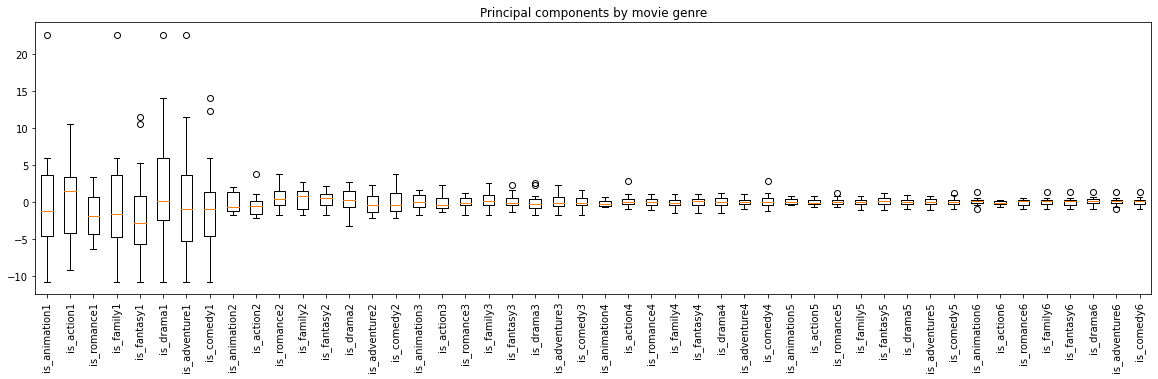

In [162]:
genre_columns = ['is_animation', 'is_action',
                 'is_romance', 'is_family',
                 'is_fantasy', 'is_drama',
                 'is_adventure', 'is_comedy']

n_columns = len(genre_columns)
n_pca = projected.shape[1]

plt.subplots(figsize = (20,5))
for position, column in enumerate(genre_columns):
    positions = range(position, position + n_columns*n_pca, n_columns)
    data = projected[imdb[column]]
    labels = [column + '1', column + '2', column + '3', column + '4', column + '5', column + '6']
    plt.boxplot(data, positions = positions, labels = labels)
    plt.xticks(rotation='vertical')
    plt.title('Principal components by movie genre')

In [163]:
imdb.to_csv(processed_data_dir / 'movie_details_db.csv', index=False)